In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

class HyperParams:
    pass
hyperparams = HyperParams()

hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 120
hyperparams.BATCH_SIZE = 32

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0010_1000"
MODEL_NAME = "0010_1000-64-aeconnect-xe4"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0299
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.4778

from tensorflow.keras.optimizers import Adam
hyperparams.OPTIMIZER = Adam(0.0005,beta_1=0.9)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelC as train
import ReportsK as reports
import AEConnectionsF as model_factory

In [4]:
##################
# MODEL DEFINITION
##################
model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [5]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = \
            dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = \
            dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/
Noisy files:20137
Nitid files:20137
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/validation/
Noisy files:4872
Nitid files:4872


In [6]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50 )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/120
630/630 [==============================] - 24s 29ms/step - loss: 0.0698 - val_loss: 0.0573
Epoch 2/120
630/630 [==============================] - 18s 28ms/step - loss: 0.0613 - val_loss: 0.0640
Epoch 3/120
630/630 [==============================] - 18s 29ms/step - loss: 0.0587 - val_loss: 0.0542
Epoch 4/120
630/630 [==============================] - 18s 28ms/step - loss: 0.0570 - val_loss: 0.0540
Epoch 5/120
630/630 [==============================] - 17s 28ms/step - loss: 0.0558 - val_loss: 0.0546
Epoch 6/120
630/630 [==============================] - 16s 25ms/step - loss: 0.0549 - val_loss: 0.0558
Epoch 7/120
630/630 [==============================] - 16s 25ms/step - loss: 0.0539 - val_loss: 0.0495
Epoch 8/120
630/630 [==============================] - 16s 25ms/step - loss: 0.0532 - val_loss: 0.0491
Epoch 9/120
630/

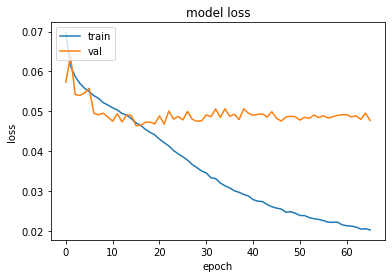

In [7]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [8]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Black image found
Black image found
Images count =4872
Best RMSENZ  =4415 (0.91)
Best MAENZ   =4431 (0.91)
Best PSNR    =4415 (0.91)
Best Accuracy=4129 (0.85)
RMSE-NZ  Pred=0.0550  Noisy=0.1609
MAE-NZ   Pred=0.0477  Noisy=0.1527
PSNR     Pred=16.5 dB Noisy=7.1 dB
Accuracy Pred=0.25    Noisy=0.08
SSM      Pred=0.89    Noisy=0.48
HOG MSE  Pred=0.10    Noisy=0.21


In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-aeconnect-xe4\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_nitid_idx076.tif


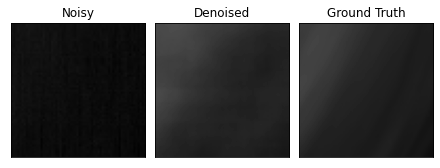

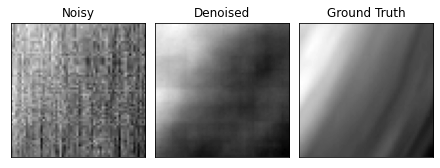

RMSE-NZ  Pred=0.0245  Noisy=0.1093 BEST
MAE-NZ   Pred=0.0217  Noisy=0.1013 BEST
PSNR     Pred=20.7 dB Noisy=7.7 dB BEST
Accuracy Pred=0.16    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.48
HOG MSE  Pred=0.19    Noisy=0.40
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_nitid_idx076.tif


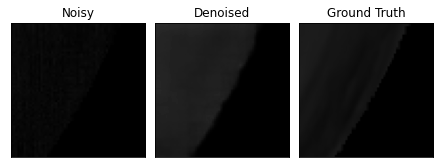

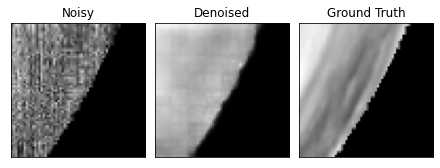

RMSE-NZ  Pred=0.0378  Noisy=0.0422 BEST
MAE-NZ   Pred=0.0275  Noisy=0.0346 BEST
PSNR     Pred=10.0 dB Noisy=9.1 dB BEST
Accuracy Pred=0.43    Noisy=0.23 BEST
SSM      Pred=0.87    Noisy=0.61
HOG MSE  Pred=0.06    Noisy=0.05
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_nitid_idx076.tif


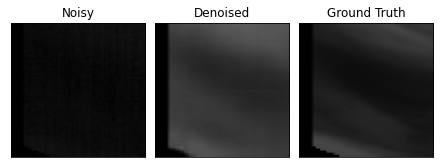

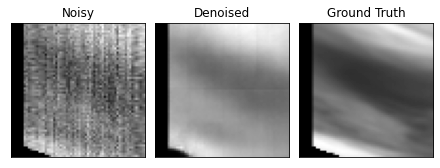

RMSE-NZ  Pred=0.0931  Noisy=0.0976 BEST
MAE-NZ   Pred=0.0865  Noisy=0.0842 WORST
PSNR     Pred=9.5 dB Noisy=9.1 dB BEST
Accuracy Pred=0.10    Noisy=0.00 BEST
SSM      Pred=0.76    Noisy=0.30
HOG MSE  Pred=0.07    Noisy=0.23
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_nitid_idx076.tif


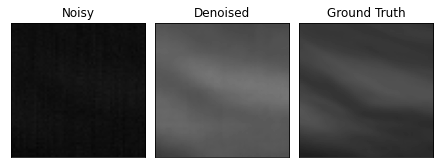

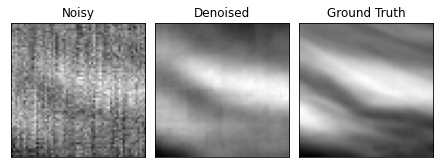

RMSE-NZ  Pred=0.1264  Noisy=0.1790 BEST
MAE-NZ   Pred=0.1241  Noisy=0.1749 BEST
PSNR     Pred=8.5 dB Noisy=5.4 dB BEST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.87    Noisy=0.30
HOG MSE  Pred=0.07    Noisy=0.46
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_nitid_idx076.tif


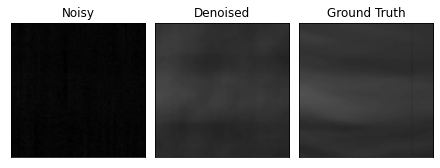

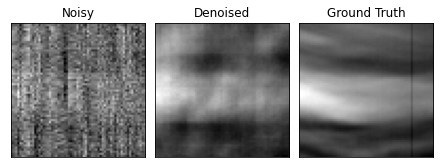

RMSE-NZ  Pred=0.0237  Noisy=0.1861 BEST
MAE-NZ   Pred=0.0195  Noisy=0.1834 BEST
PSNR     Pred=22.5 dB Noisy=4.6 dB BEST
Accuracy Pred=0.28    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.23
HOG MSE  Pred=0.14    Noisy=0.39
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_nitid_idx076.tif


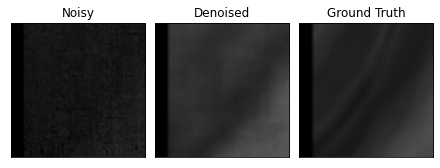

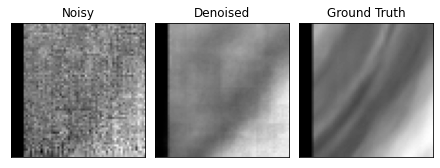

RMSE-NZ  Pred=0.0547  Noisy=0.0728 BEST
MAE-NZ   Pred=0.0492  Noisy=0.0602 BEST
PSNR     Pred=14.9 dB Noisy=12.4 dB BEST
Accuracy Pred=0.10    Noisy=0.04 BEST
SSM      Pred=0.86    Noisy=0.56
HOG MSE  Pred=0.09    Noisy=0.17
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_nitid_idx076.tif


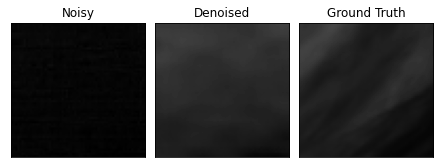

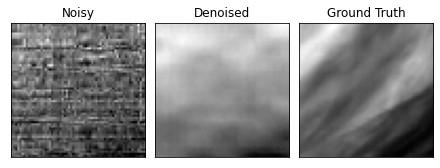

RMSE-NZ  Pred=0.0482  Noisy=0.1143 BEST
MAE-NZ   Pred=0.0399  Noisy=0.1044 BEST
PSNR     Pred=15.0 dB Noisy=7.5 dB BEST
Accuracy Pred=0.16    Noisy=0.00 BEST
SSM      Pred=0.82    Noisy=0.26
HOG MSE  Pred=0.15    Noisy=0.21
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_nitid_idx076.tif


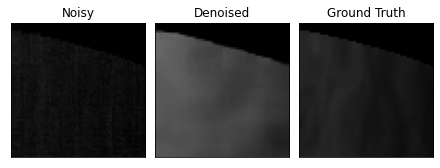

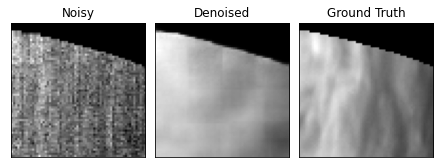

RMSE-NZ  Pred=0.1563  Noisy=0.0540 WORST
MAE-NZ   Pred=0.1389  Noisy=0.0470 WORST
PSNR     Pred=1.3 dB Noisy=10.6 dB WORST
Accuracy Pred=0.17    Noisy=0.08 BEST
SSM      Pred=0.63    Noisy=0.41
HOG MSE  Pred=0.07    Noisy=0.06
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_nitid_idx076.tif


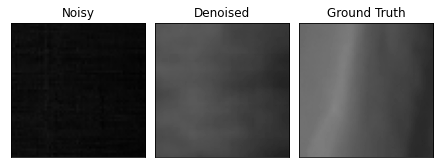

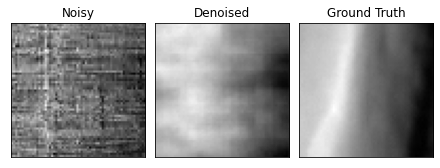

RMSE-NZ  Pred=0.0870  Noisy=0.3118 BEST
MAE-NZ   Pred=0.0713  Noisy=0.2974 BEST
PSNR     Pred=15.5 dB Noisy=4.4 dB BEST
Accuracy Pred=0.07    Noisy=0.00 BEST
SSM      Pred=0.86    Noisy=0.28
HOG MSE  Pred=0.21    Noisy=0.36
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_nitid_idx076.tif


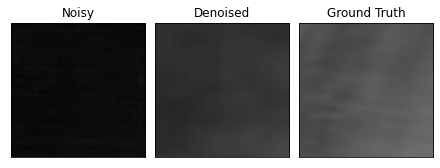

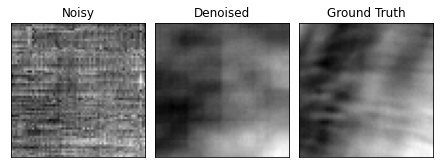

RMSE-NZ  Pred=0.1348  Noisy=0.2883 BEST
MAE-NZ   Pred=0.1332  Noisy=0.2864 BEST
PSNR     Pred=10.1 dB Noisy=3.5 dB BEST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.84    Noisy=0.41
HOG MSE  Pred=0.05    Noisy=0.06
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_nitid_idx076.tif


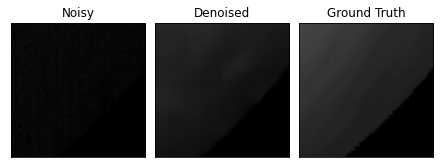

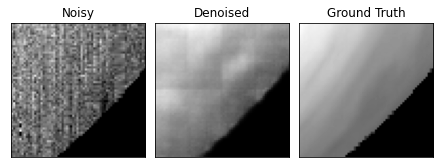

RMSE-NZ  Pred=0.0599  Noisy=0.1343 BEST
MAE-NZ   Pred=0.0516  Noisy=0.1226 BEST
PSNR     Pred=13.2 dB Noisy=6.2 dB BEST
Accuracy Pred=0.20    Noisy=0.11 BEST
SSM      Pred=0.86    Noisy=0.55
HOG MSE  Pred=0.08    Noisy=0.19
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_nitid_idx076.tif


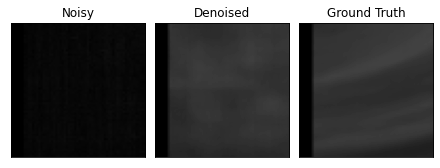

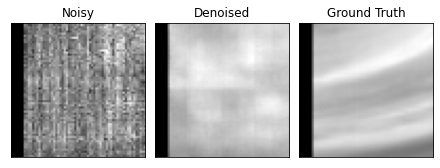

RMSE-NZ  Pred=0.0229  Noisy=0.1755 BEST
MAE-NZ   Pred=0.0183  Noisy=0.1729 BEST
PSNR     Pred=21.2 dB Noisy=3.5 dB BEST
Accuracy Pred=0.33    Noisy=0.00 BEST
SSM      Pred=0.96    Noisy=0.25
HOG MSE  Pred=0.11    Noisy=0.25
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_nitid_idx076.tif


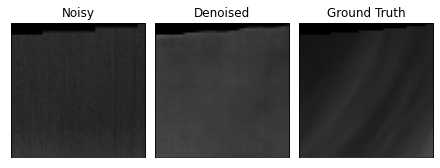

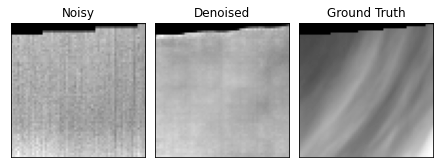

RMSE-NZ  Pred=0.0864  Noisy=0.0385 WORST
MAE-NZ   Pred=0.0789  Noisy=0.0294 WORST
PSNR     Pred=10.3 dB Noisy=17.3 dB WORST
Accuracy Pred=0.07    Noisy=0.25 WORST
SSM      Pred=0.73    Noisy=0.84
HOG MSE  Pred=0.11    Noisy=0.12
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_nitid_idx076.tif


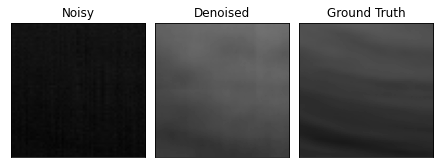

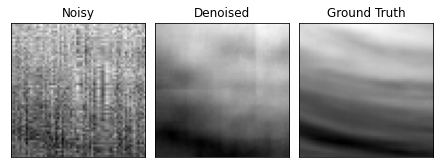

RMSE-NZ  Pred=0.0970  Noisy=0.1778 BEST
MAE-NZ   Pred=0.0945  Noisy=0.1697 BEST
PSNR     Pred=11.2 dB Noisy=6.0 dB BEST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.89    Noisy=0.31
HOG MSE  Pred=0.19    Noisy=0.49
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_nitid_idx076.tif


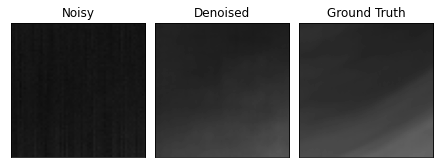

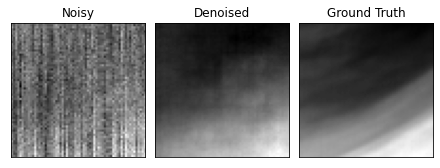

RMSE-NZ  Pred=0.0392  Noisy=0.1427 BEST
MAE-NZ   Pred=0.0340  Noisy=0.1285 BEST
PSNR     Pred=20.0 dB Noisy=8.8 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.96    Noisy=0.71
HOG MSE  Pred=0.15    Noisy=0.31
******************************************************


In [11]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
                dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
                dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )